In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

from BayesLeNet5 import BayesLeNet5

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 1024
val_dataset = MNIST(
    root="data", 
    download=True, 
    train=False, 
    transform=transforms.ToTensor()
)
val_loader = DataLoader(
    dataset=val_dataset, 
    batch_size=batch_size, 
    shuffle=False
)

model = BayesLeNet5()
model.to(device)

checkpoint = torch.load('models/bayeslenet5.pt')
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [3]:
n = 100
n_samples_list = [1, 5, 10, 50, 100, 500, 1000]

accuracies = []
pbar1 = tqdm(total=len(n_samples_list), leave=False)
for n_samples in n_samples_list:
    pbar1.set_description(f"n. samples: {n_samples}")
    
    acc = []
    pbar2 = tqdm(total=n, leave=False)
    for _ in range(n):    
        with torch.no_grad():
            pbar3 = tqdm(total=len(val_loader), leave=False)
            correct = 0
            for i, (input, target) in enumerate(val_loader):
                input = input.to(device)
                target = target.to(device)
                samples = torch.empty((n_samples, input.shape[0], 10)).to(device)
                for j in range(n_samples):
                    samples[j, ...] = F.softmax(model(input), dim=1)
                _, labels = samples.mean(dim=0).max(1)
                correct += labels.eq(target).sum()
                pbar3.update(1)
            pbar3.close()

        acc.append(correct.cpu().item() * 100. / len(val_dataset))
        pbar2.update(1)
    pbar2.close()
    
    accuracies.append(acc)
    pbar1.update(1)
pbar1.close()

pd.DataFrame(
    np.array(accuracies).T,
    columns=n_samples_list
).to_csv(
    'sample_accuracies.csv',
    index=False
)

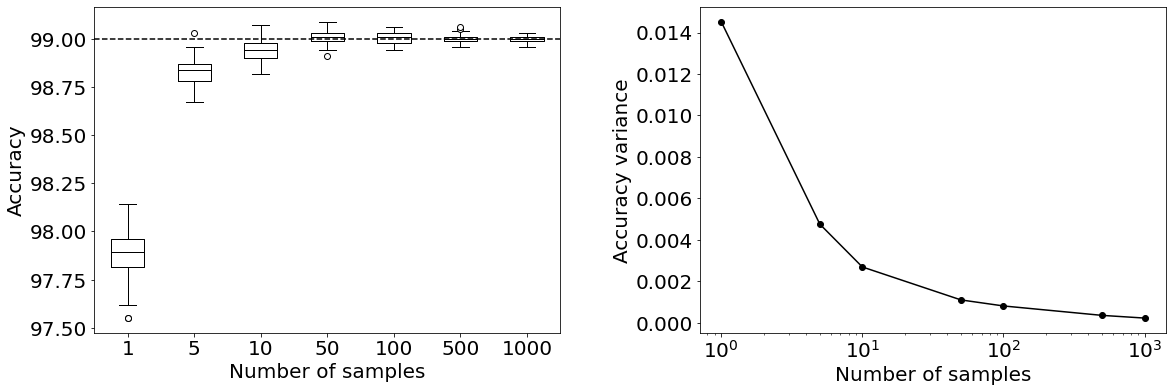

In [4]:
df = pd.read_csv('sample_accuracies.csv')

matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['lines.linewidth'] = 1.5

_, ax = plt.subplots(1, 2, figsize=(3.2*6, 1*6))

ax[0].boxplot(
    df.values, 
    flierprops=dict(markerfacecolor='white', marker='o'), 
    boxprops=dict(color='black'), 
    medianprops=dict(color='black'), 
    whiskerprops=dict(color='black', linestyle='-')
)
ax[0].set_xlabel('Number of samples')
ax[0].set_ylabel('Accuracy')
ax[0].set_xticklabels(df.columns.tolist())
ax[0].axhline(
    df['1000'].median(), 
    linestyle='--', 
    color='black'
)

ax[1].plot(
    df.columns.astype(int).tolist(), 
    df.var(), 
    color='black',
    marker='o'
)
ax[1].set_xscale('log')
ax[1].set_xlabel('Number of samples')
ax[1].set_ylabel('Accuracy variance')

plt.subplots_adjust(wspace=0.3)
#plt.savefig(figure4.pdf, format='pdf', transparent=True, dpi=300, bbox_inches='tight')
plt.show()